In [34]:
# #to access kaggle datasets
# !pip install kaggle
# #Math operations
# !pip install numpy
# #Machine learning

In [147]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
# from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

from tensorflow.keras.models import load_model


from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

In [148]:
# # Colab's file access feature
# from google.colab import files

# #retrieve uploaded file
# uploaded = files.upload()

# #print results
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [149]:
# !kaggle datasets list

In [150]:
# #download earthquake data, will take 30-60 seconds
# !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria/downloads/cell-images-for-detecting-malaria.zip/1

In [151]:
# #unzip training data for usage, will take about 5 minutes (its big)
# !ls
# !unzip cell-images-for-detecting-malaria.zip
# !ls

In [152]:
PARA_DIR = 'cell_images/Parasitized'
UNIF_DIR = 'cell_images/Uninfected'

In [153]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

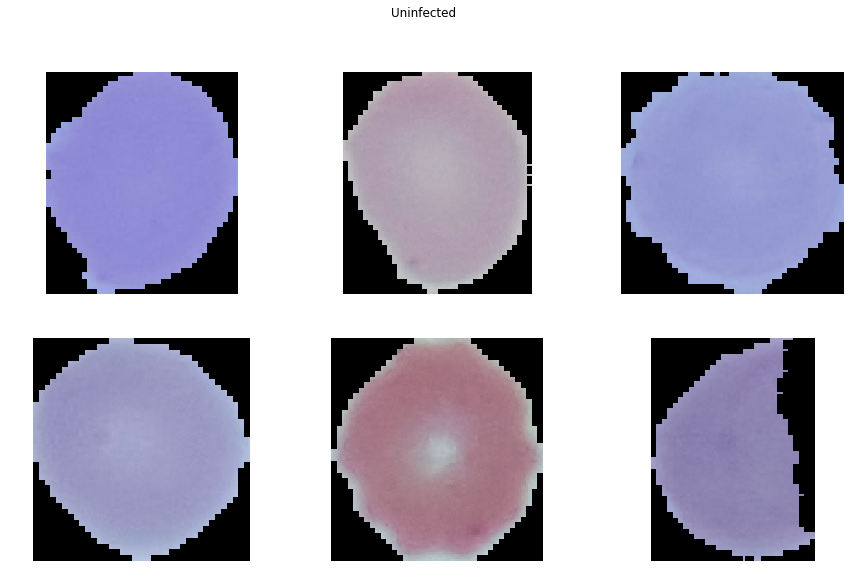

In [154]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

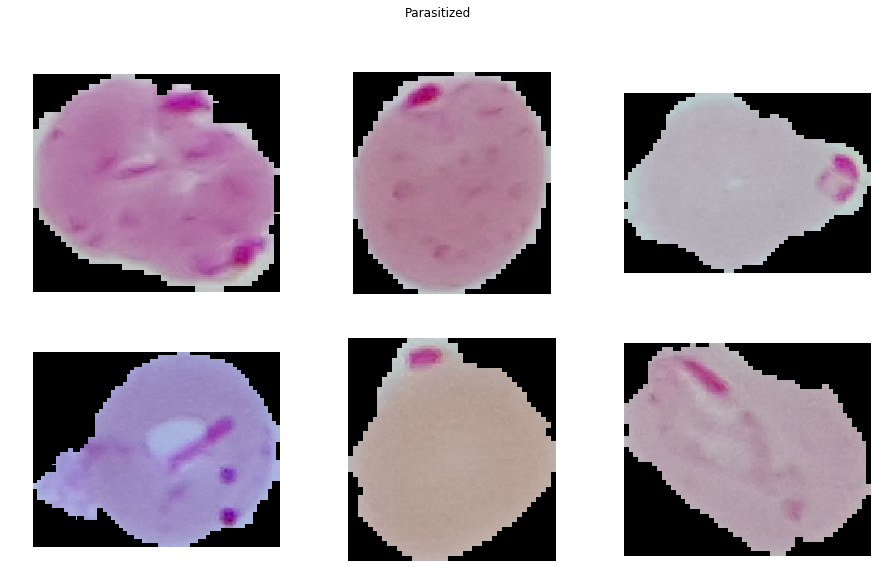

In [155]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [156]:
%%time
data=[]
labels=[]
Parasitized=os.listdir("cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((125, 125))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((125, 125))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")




CPU times: user 25.4 s, sys: 10 s, total: 35.4 s
Wall time: 1min 9s


In [157]:
%%time
Cells=np.array(data)
labels=np.array(labels)

CPU times: user 681 ms, sys: 1.13 s, total: 1.81 s
Wall time: 1.87 s


In [158]:
np.save("Cells",Cells)
np.save("labels",labels)

In [159]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [160]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [161]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

In [162]:
%%time
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

CPU times: user 4.45 s, sys: 13.2 s, total: 17.6 s
Wall time: 30.2 s


In [163]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [164]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [165]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed
np.random.seed(0)

In [166]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
import keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

from tensorflow.keras import optimizers

In [167]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [168]:
#instantiate the model
height = 125
width = 125
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 29, 29, 32)       

In [169]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

# tf.random.set_seed(42)
tf.__version__



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.0.1'

In [170]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)



In [171]:
%%time
import datetime

logdir = os.path.join('tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0005)


callbacks = [reduce_lr, tensorboard_callback]



CPU times: user 384 µs, sys: 2.15 ms, total: 2.53 ms
Wall time: 6.12 ms


# Model ADAM

In [173]:
%%time
#compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history = model.fit(x=x_train, y=y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks,
                    verbose=1)

Train on 24664 samples, validate on 2740 samples
Epoch 1/25
24664/24664 [==============================] - 465s 19ms/sample - loss: 0.5144 - accuracy: 0.7846 - val_loss: 0.6436 - val_accuracy: 0.7982
Epoch 2/25
24664/24664 [==============================] - 450s 18ms/sample - loss: 0.2281 - accuracy: 0.9205 - val_loss: 0.2735 - val_accuracy: 0.9099
Epoch 3/25
24664/24664 [==============================] - 447s 18ms/sample - loss: 0.1849 - accuracy: 0.9383 - val_loss: 0.2420 - val_accuracy: 0.9172
Epoch 4/25
24664/24664 [==============================] - 448s 18ms/sample - loss: 0.1674 - accuracy: 0.9432 - val_loss: 0.3102 - val_accuracy: 0.8996
Epoch 5/25
24664/24664 [==============================] - 453s 18ms/sample - loss: 0.1517 - accuracy: 0.9486 - val_loss: 0.1918 - val_accuracy: 0.9296
Epoch 6/25
24664/24664 [==============================] - 451s 18ms/sample - loss: 0.1489 - accuracy: 0.9500 - val_loss: 0.1706 - val_accuracy: 0.9380
Epoch 7/25
24664/24664 [=====================

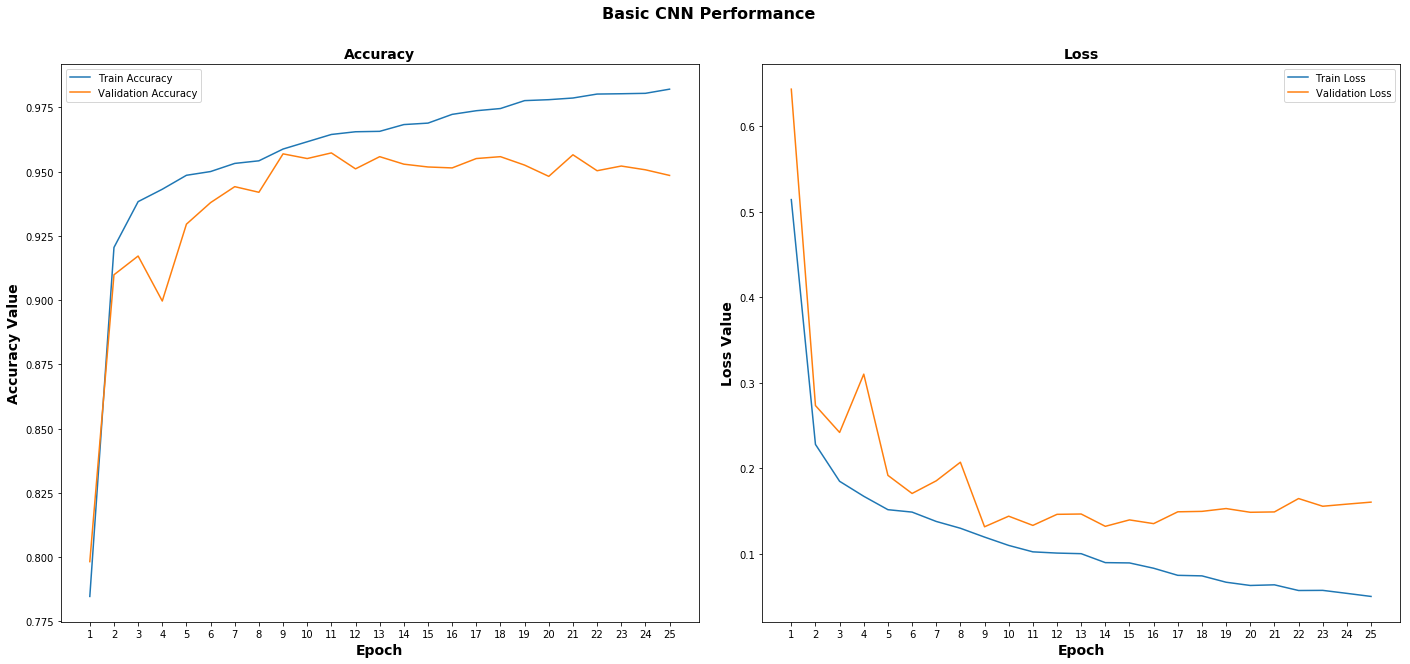

In [262]:
from sklearn.metrics import accuracy_score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
t = f.suptitle('Basic CNN Performance', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.1)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

In [175]:
## Loading tensorboard
# import tensorflow as tf
# from tensorflow.python.summary import summary_iterator
# import os
# log_base_dir = 'Desktop/tensorboard_logs'
# os.makedirs(log_base_dir,exist_ok = True)
# %tensorboard --logdir {log_base_dir}

In [176]:
# from numpy import loadtxt
# from keras.models import load_model
# model = load_model('.mdl_wts.hdf5')

In [263]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

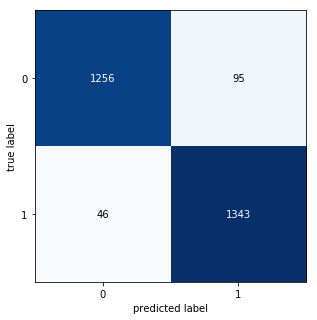

CPU times: user 304 ms, sys: 40 ms, total: 344 ms
Wall time: 212 ms


In [264]:
%%time
import mlxtend
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [179]:
#model.save('models_app/my_model.h5')

In [180]:
x_test.shape[0]

2740

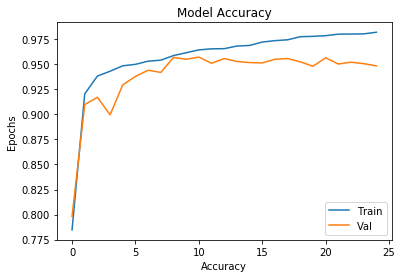

In [265]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [271]:
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)


In [183]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

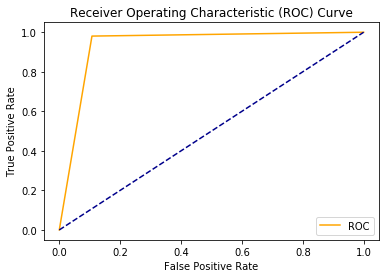

In [259]:
plot_roc_curve(fpr_keras, tpr_keras)

In [185]:
from sklearn.metrics import classification_report

In [186]:


print('{}'.format(classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1351
           1       0.93      0.97      0.95      1389

    accuracy                           0.95      2740
   macro avg       0.95      0.95      0.95      2740
weighted avg       0.95      0.95      0.95      2740



# Model 2 SGD

In [187]:
#instantiate the model
height = 125
width = 125
classes = 2
channels = 3
model2 = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model2.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
dropout_28 (Dropout)         (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 29, 29, 32)       

In [188]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model2.compile( loss = "categorical_crossentropy", 
               optimizer = sgd, 
               metrics=['accuracy']
             )
history2 = model2.fit(x=x_train, y=y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks,
                    verbose=1)

Train on 24664 samples, validate on 2740 samples
Epoch 1/25
24664/24664 [==============================] - 448s 18ms/sample - loss: 0.9331 - accuracy: 0.6397 - val_loss: 1.1481 - val_accuracy: 0.5825
Epoch 2/25
24664/24664 [==============================] - 441s 18ms/sample - loss: 0.4018 - accuracy: 0.8668 - val_loss: 0.5411 - val_accuracy: 0.8336
Epoch 3/25
24664/24664 [==============================] - 437s 18ms/sample - loss: 0.2534 - accuracy: 0.9177 - val_loss: 0.2475 - val_accuracy: 0.9354
Epoch 4/25
24664/24664 [==============================] - 439s 18ms/sample - loss: 0.2561 - accuracy: 0.9214 - val_loss: 0.3903 - val_accuracy: 0.9026
Epoch 5/25
24664/24664 [==============================] - 440s 18ms/sample - loss: 0.2173 - accuracy: 0.9333 - val_loss: 0.1635 - val_accuracy: 0.9438
Epoch 6/25
24664/24664 [==============================] - 440s 18ms/sample - loss: 0.1834 - accuracy: 0.9411 - val_loss: 0.3561 - val_accuracy: 0.8672
Epoch 7/25
24664/24664 [=====================

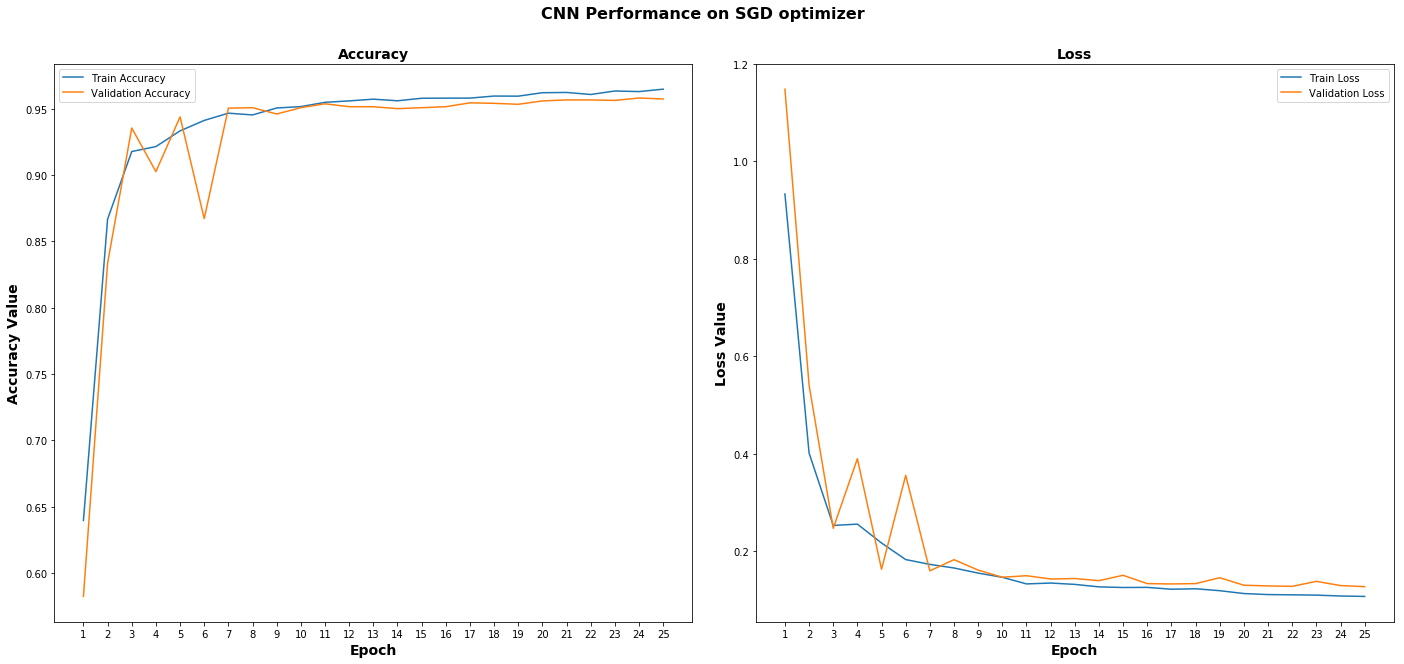

In [261]:
from sklearn.metrics import accuracy_score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
t = f.suptitle('CNN Performance on SGD optimizer', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.1)

max_epoch = len(history2.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

In [190]:
from sklearn.metrics import confusion_matrix
pred = model2.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

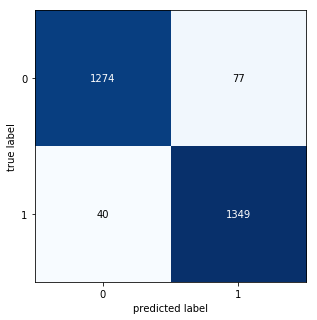

CPU times: user 306 ms, sys: 34.3 ms, total: 340 ms
Wall time: 200 ms


In [191]:
%%time
import mlxtend
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [225]:
model2.save('models_app/my_model_sgd.h5')

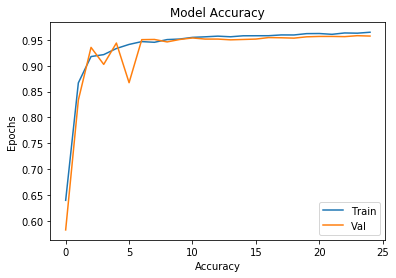

In [193]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [269]:
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)

In [270]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

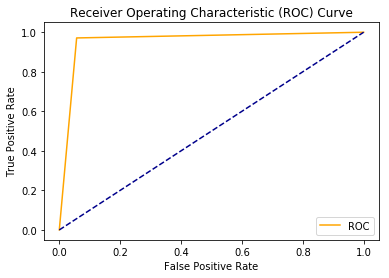

In [196]:
plot_roc_curve(fpr_keras, tpr_keras)

In [197]:
from sklearn.metrics import classification_report

In [198]:
print('{}'.format(classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1351
           1       0.95      0.97      0.96      1389

    accuracy                           0.96      2740
   macro avg       0.96      0.96      0.96      2740
weighted avg       0.96      0.96      0.96      2740



# Model 3 RMSPROP

In [199]:
#instantiate the model
height = 125
width = 125
classes = 2
channels = 3
model3 = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model3.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
dropout_32 (Dropout)         (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 29, 29, 32)       

In [200]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop', metrics = ['accuracy'])

history3 = model3.fit(x=x_train, y=y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks,
                    verbose=1)


Train on 24664 samples, validate on 2740 samples
Epoch 1/25
24664/24664 [==============================] - 511s 21ms/sample - loss: 0.4874 - accuracy: 0.8054 - val_loss: 0.4934 - val_accuracy: 0.8595
Epoch 2/25
24664/24664 [==============================] - 477s 19ms/sample - loss: 0.2169 - accuracy: 0.9240 - val_loss: 0.2336 - val_accuracy: 0.9124
Epoch 3/25
24664/24664 [==============================] - 467s 19ms/sample - loss: 0.1767 - accuracy: 0.9396 - val_loss: 0.2148 - val_accuracy: 0.9212
Epoch 4/25
24664/24664 [==============================] - 466s 19ms/sample - loss: 0.1649 - accuracy: 0.9469 - val_loss: 0.1636 - val_accuracy: 0.9493
Epoch 5/25
24664/24664 [==============================] - 458s 19ms/sample - loss: 0.1574 - accuracy: 0.9497 - val_loss: 0.1973 - val_accuracy: 0.9274
Epoch 6/25
24664/24664 [==============================] - 456s 18ms/sample - loss: 0.1533 - accuracy: 0.9500 - val_loss: 0.1529 - val_accuracy: 0.9511
Epoch 7/25
24664/24664 [=====================

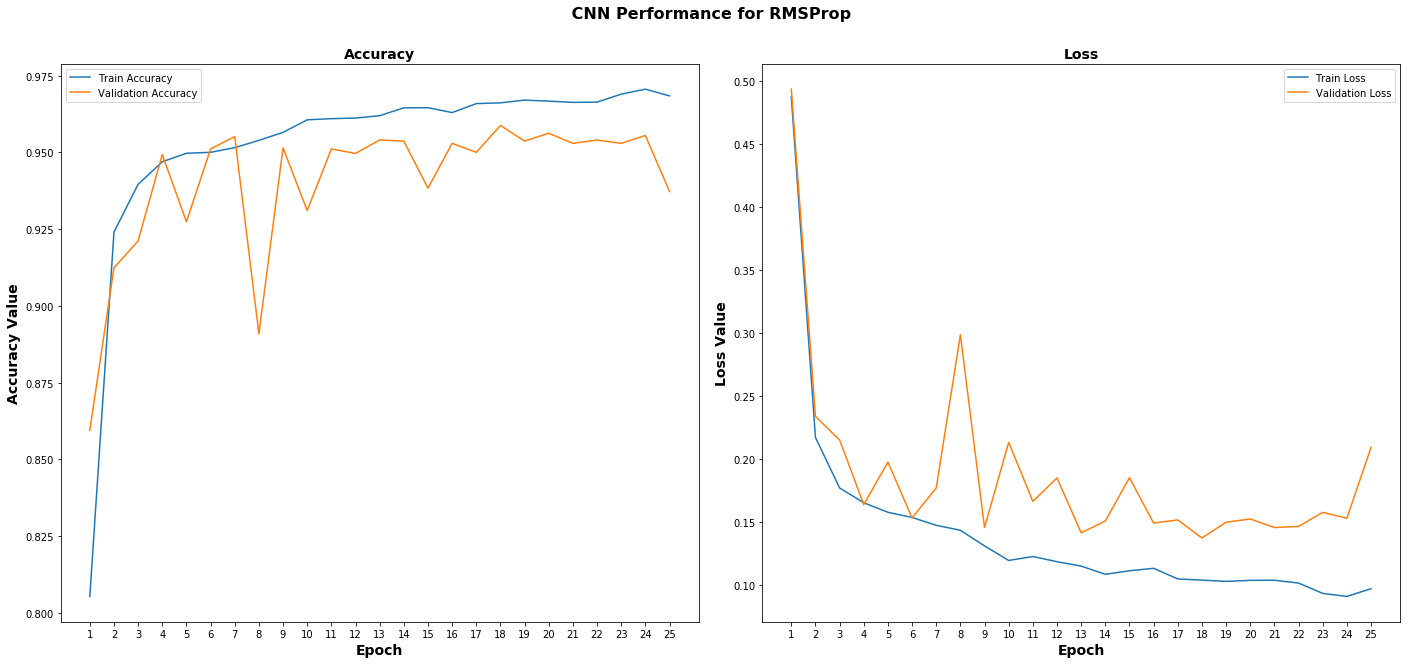

In [216]:
from sklearn.metrics import accuracy_score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
t = f.suptitle(' CNN Performance for RMSProp', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.1)

max_epoch = len(history3.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

In [217]:
from sklearn.metrics import confusion_matrix
pred = model3.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

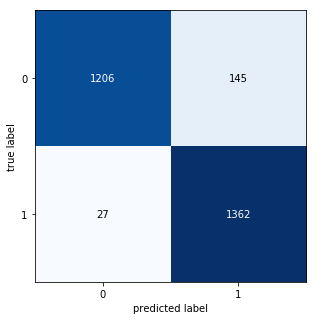

CPU times: user 305 ms, sys: 29.9 ms, total: 335 ms
Wall time: 199 ms


In [218]:
%%time
import mlxtend
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [226]:
model3.save('models_app/my_model_RMSProp.h5')

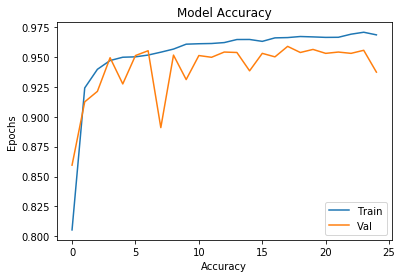

In [220]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [221]:
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9366168249101138

In [222]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

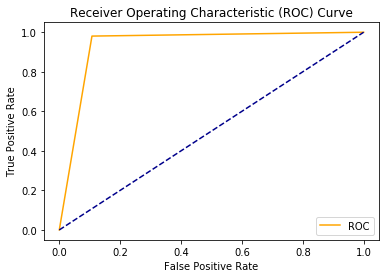

In [223]:
plot_roc_curve(fpr_keras, tpr_keras)

In [224]:
from sklearn.metrics import classification_report

In [210]:
print('{}'.format(classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1351
           1       0.90      0.98      0.94      1389

    accuracy                           0.94      2740
   macro avg       0.94      0.94      0.94      2740
weighted avg       0.94      0.94      0.94      2740



In [280]:
# # Loading tensorboard
# import tensorflow as tf
# from tensorflow.python.summary import summary_iterator
# import os
# log_base_dir = 'Desktop/tensorboard_logs'
# os.makedirs(log_base_dir,exist_ok = True)
# %tensorboard --logdir {log_base_dir}

In [211]:
# # get predictions on the test set
# y_hat = model.predict(x_test)

# # define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
# malaria_labels = ['Parasitized','Uninfected']

In [212]:
# x_test.shape[0]

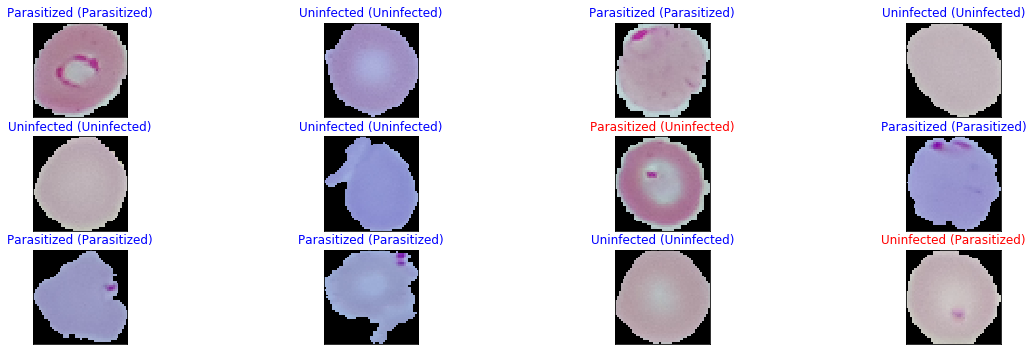

In [72]:
# # plot a random sample of test images, their predicted labels, and ground truth
# fig = plt.figure(figsize=(20, 8))
# for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
#     ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(x_test[idx]))
#     pred_idx = np.argmax(y_hat[idx])
#     true_idx = np.argmax(y_test[idx])
#     ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
#                  color=("blue" if pred_idx == true_idx else "red"))